In [39]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection for content losses done by Logistic Regression

# Due to many zero losses especially in content losses, a binary regression was tested to distinguish between occured losses and no losses. 
# The before applied elastic net result showed that the elastic net algorithm might be a bit too complex for the moderate size of training set 
# and the imbalnced distribution with in the response (many zero losses compared to only a very a left skewed distribution of occured content losses)  
# *Sources*
# Geron 2019: https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch04.html#idm45022190228392


import sys
import re
import datetime
from pathlib import Path
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


sys.path.insert(0, "../../")
import utils.feature_selection as fs
import utils.training as t
import utils.evaluation as e
import utils.evaluation_metrics as em
import utils.figures as f
import utils.settings as s
import utils.pipelines as p
import utils.preprocessing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

import contextlib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

## settings for cv
kfolds_and_repeats = 10, 5  # <k-folds, repeats> for nested cv
cv = RepeatedStratifiedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)

## save models and their evaluation in following folders:
Path(f"../models_trained/can_tho/chance_of_loss/nested_cv_models").mkdir(parents=True, exist_ok=True)
Path(f"../models_trained/can_tho/chance_of_loss/final_models").mkdir(parents=True, exist_ok=True)
Path(f"../models_evaluation/can_tho/chance_of_loss").mkdir(parents=True, exist_ok=True)
Path(f"../selected_features/can_tho/chance_of_loss").mkdir(parents=True, exist_ok=True)




<Figure size 2000x1000 with 0 Axes>

In [40]:
#target = "Target_relative_contentloss_euro"
target = "abs_closs_VND"


## load DS for relative content loss
#df_candidates = pd.read_excel("../../input_survey_data/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel("../../input_survey_data/input_data_cantho_2013_quicktest.xlsx", header=0)


In [41]:
## fix data cleaning 
df_candidates = df_candidates.replace({99.0: np.nan, 88.0: np.nan})

In [42]:
## merge both closs targets

pd.options.display.float_format = '{:.2f}'.format

df_candidates["abs_closs_VND"]  = df_candidates.Target_eloss + df_candidates.Target_gloss
np.round(df_candidates["abs_closs_VND"], 2).describe()


# df_candidates = df_candidates.drop(["Target_eloss", "Target_gloss", "Target_bred"], axis=1)


count        377.00
mean     2065453.58
std      5142646.63
min            0.00
25%            0.00
50%       200000.00
75%      1500000.00
max     60000000.00
Name: abs_closs_VND, dtype: float64

### Explore variable's key statistics - re they similar to HCMC ?


In [43]:
# df_candidates["Direct_damage"].describe()  # probably this variable was self-calculated by the researcher


## content value
df_candidates["content_value_VND"] = df_candidates.cv_goods + df_candidates.cv_equipment
# print(df_candidates["content_value_VND"].describe())


## absolute content loss
# df_candidates["abs_closs_VND"].describe()


## Target business reduction
# df_candidates["Target_bred"].describe()


## Can Tho
# Abs Closs: median: 8 €, 3.Quantile=60€, mean 80 € , max: 2310 €
# rloss : median: 0.01 , mean: max:
# CV: mean 3000 €, median: 300 € , max= 392 600 € (no inflation corrected)
## Bred : mean 40%, median 40%

In [44]:

## Target relative closs
pd.set_option('use_inf_as_na', True)
#t = t.apply(pd.to_numeric)
# t = t.dropna()
#t[["abs_closs_VND", "content_value_VND"]] = t[["abs_closs_VND", "content_value_VND"]].fillna(0, inplace=True)
df_candidates["Target_rcloss"] = df_candidates["abs_closs_VND"] / df_candidates["content_value_VND"]
# set all zero-loss cases to 0
df_candidates = df_candidates.apply(pd.to_numeric)
df_candidates.Target_rcloss[df_candidates.Target_rcloss.isna()] = 0.0

## rloss > cv
print("Records with relative content loss exceding the content values for businesses:", sum(df_candidates.Target_rcloss > 1.0) )
# t.Target_rcloss[t.Target_rcloss > 1.0]  = 1.0
# print(all_input_contentloss[all_input_contentloss.Target_relative_contentloss_euro > 0.99 ])
df_candidates[["abs_closs_VND", "content_value_VND", "Target_rcloss", "Target_bred"]].describe()


Records with relative content loss exceding the content values for businesses: 13


,abs_closs_VND,content_value_VND,Target_rcloss,Target_bred
count,377.00,374.00,389.00,378.00
mean,2065453.58,79952032.09,0.17,40.70
std,5142646.63,545848463.16,0.54,21.89
min,0.00,0.00,0.00,0.00
25%,0.00,2000000.00,0.00,25.00
50%,200000.00,7000000.00,0.00,40.00
75%,1500000.00,25000000.00,0.10,50.00
max,60000000.00,10200000000.00,5.00,100.00


In [45]:
# df_candidates.abs_closs_VND.describe()  # max abs loss is 2300 €


In [46]:
# ## explore cases where rloss > cv
# tt = t.loc[t.Target_rcloss > 1.0, :]
# tt.sort_values("abs_closs_VND", ascending=False)

## drop these records where rloss > cv
# t = t.loc[~(t.Target_rcloss >= 1.0), :]

## get rloss to similar ratio as for HCMC (rloss=0.3)
df_candidates =  df_candidates.loc[~(df_candidates.Target_rcloss >= .5), :]   # removed ~ 15 records with higher loss ratio than 50%
df_candidates[["abs_closs_VND", "content_value_VND", "Target_rcloss", "Target_bred"]].describe()

## Can Tho
# Abs Closs: median: 1 €, 3.Quantile: 50 €, mean 74 € , max:  2310 €
# rloss : median: 0.0 , mean: 0.05,  max: 0.48
# CV: mean 3340 €, median: 310 € , max: 392.610 € (no inflation corrected)
## Bred : mean 40%, median 40%

,abs_closs_VND,content_value_VND,Target_rcloss,Target_bred
count,346.00,343.00,358.00,347.00
mean,1913803.47,86855714.29,0.05,40.56
std,5076497.88,569542505.62,0.10,21.33
min,0.00,0.00,0.00,0.00
25%,0.00,2400000.00,0.00,30.00
50%,25500.00,8000000.00,0.00,40.00
75%,1300000.00,30000000.00,0.07,50.00
max,60000000.00,10200000000.00,0.48,100.00


### Verify cv calculation for HCMC
by testing how cv value would be for CanTho when same approach as in HCMC is used


In [47]:
df_candidates.columns

Index(['No', 'shp_sector', 'Unnamed: 2', 'Unnamed: 3', 'flood_experience',
       'flood_type', 'warning_time', 'applied_emergency', 'emergency_1',
       'emergency_2', 'emergency_3', 'emergency_4', 'emergency_5',
       'emergency_6', 'emergency_7', 'emergency_8', 'emergency_9',
       'emergency_effect', 'wd', 'inud', 'contamination', 'fv',
       'overall_problem_building', 'contents_cost_repalce', 'Target_eloss',
       'Target_gloss', 'Target_bred', 'precaution_1', 'precaution_2',
       'precaution_3', 'precaution_4', 'precaution_5', 'precaution_6',
       'precaution_7', 'Efficacy of adaptation measure',
       'Efficacy of adaptation measure.1', 'perception_1', 'perception_2',
       'perception_3', 'perception_4', 'perception_5', 'perception_6',
       'perception_7', 'perception_8', 'perception_9', 'perception_10', 'Year',
       'ownership', 'b_age', 'building_value', 'hh_income', 'Opened year',
       'number_employees', 'shp_avg_monthly_sale', 'cv_goods', 'cv_equipment',


In [48]:
df_candidates.floors.describe()  # meaningless or only flat buildings (or count ground floor = 0, first level = 1 ?)

df_candidates.wd.describe()  # water depth [cm]
# median: 0.20cm, mean: 0.25m, max: 0.80m

count   347.00
mean     26.00
std      16.35
min       0.00
25%      10.00
50%      20.00
75%      40.00
max      80.00
Name: wd, dtype: float64

In [49]:
df_candidates["building_value"].describe()

df_candidates["building_value"] = df_candidates["building_value"].replace(
    {
        1.0 : 2.5,
        2.0 : 7.5,
        3.0 : 15,
        4.0 : 35,
        5.0 : 75,
        6.0 : 150,
        7.0 : 350,
        8.0 : 750,
        9.0 : 1500,
        10.0 : 3500,
    }
)
## bv
# median: 75 mVND, mean: 75 mVND, max 3500 mVND

In [50]:
## fix floors :
## problably 0 : bungalow with only ground floor --> in HCMC would be this 1 floor
df_candidates["floors"] = df_candidates["floors"] +1 
df_candidates["floors"].describe()

## remove reecords with more than 3 floors
df_candidates = df_candidates.loc[df_candidates["floors"] <= 3, :]  # rm ~ 20 records
df_candidates["floors"].describe()


count   325.00
mean      1.46
std       0.68
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       3.00
Name: floors, dtype: float64

In [59]:
df_candidates.columns

Index(['No', 'shp_sector', 'Unnamed: 2', 'Unnamed: 3', 'flood_experience',
       'flood_type', 'warning_time', 'applied_emergency', 'emergency_1',
       'emergency_2', 'emergency_3', 'emergency_4', 'emergency_5',
       'emergency_6', 'emergency_7', 'emergency_8', 'emergency_9',
       'emergency_effect', 'wd', 'inud', 'contamination', 'fv',
       'overall_problem_building', 'contents_cost_repalce', 'Target_eloss',
       'Target_gloss', 'Target_bred', 'precaution_1', 'precaution_2',
       'precaution_3', 'precaution_4', 'precaution_5', 'precaution_6',
       'precaution_7', 'Efficacy of adaptation measure',
       'Efficacy of adaptation measure.1', 'perception_1', 'perception_2',
       'perception_3', 'perception_4', 'perception_5', 'perception_6',
       'perception_7', 'perception_8', 'perception_9', 'perception_10', 'Year',
       'ownership', 'b_age', 'building_value', 'hh_income', 'Opened year',
       'number_employees', 'shp_avg_monthly_sale', 'cv_goods', 'cv_equipment',


In [62]:
df_candidates["content_value_VND"].describe()
t = df_candidates.loc[df_candidates["content_value_VND"] <= 7000000.00, :]
t.number_employees.describe()  
## --> most of the shops with small cv are indead very small businesses

count   163.00
mean      1.45
std       1.12
min       1.00
25%       1.00
50%       1.00
75%       1.00
max      10.00
Name: number_employees, dtype: float64

In [55]:
df_candidates["content_value_mVND_self"] = df_candidates["building_value"] / df_candidates["floors"]
df_candidates["content_value_mVND_self"] .describe()

## cv self
# up to 3 floor-levels:  median 1350 €, mean: 4580 €, max: 134 700 €

## cv survey question
# median: 300 € , mean: 3300 €, max: 392 610

count    324.00
mean     119.34
std      275.86
min        0.00
25%       15.00
50%       35.00
75%      116.67
max     3500.00
Name: content_value_mVND_self, dtype: float64

### Verify: socio economic status is similar
check if income , monthly sale etc is similar to the HCMC shophouses


In [27]:
df_candidates[["hh_income", "number_employees", "shp_avg_monthly_sale"]].describe()

,hh_income,number_employees,shp_avg_monthly_sale
count,344.00,345.00,318.00
mean,4.50,2.25,43353144.65
std,1.15,3.43,506265993.20
min,1.00,1.00,0.00
25%,4.00,1.00,2425000.00
50%,4.00,1.00,5000000.00
75%,5.00,2.00,10000000.00
max,8.00,37.00,9000000000.00


In [30]:
# df_candidates[df_candidates.number_employees>=20]  # 5 businesses with more than 20 employees

## --> first keep also larger shops due that their absolute losses ae similar high aas for HCMC around 2500 €

,No,shp_sector,Unnamed: 2,Unnamed: 3,flood_experience,flood_type,warning_time,applied_emergency,emergency_1,emergency_2,emergency_3,emergency_4,emergency_5,emergency_6,emergency_7,emergency_8,emergency_9,emergency_effect,wd,inud,contamination,fv,overall_problem_building,contents_cost_repalce,Target_eloss,Target_gloss,Target_bred,precaution_1,precaution_2,precaution_3,precaution_4,precaution_5,precaution_6,precaution_7,Efficacy of adaptation measure,Efficacy of adaptation measure.1,perception_1,perception_2,perception_3,perception_4,perception_5,perception_6,perception_7,perception_8,perception_9,perception_10,Year,ownership,b_age,building_value,hh_income,Opened year,number_employees,shp_avg_monthly_sale,cv_goods,cv_equipment,b_area,floors,distance_to_river,b_elevation,b_type,Direct_damage,abs_closs_VND,content_value_VND,Target_rcloss
137,138.00,5.00,NaN,NaN,3.00,1.00,7.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00,10.00,2.50,1.00,2.00,0.00,0.00,0.00,7000000.00,35.00,1.00,0.00,0.00,0.00,0.00,3.00,10.00,5.00,3.00,5.00,1.00,3.00,5.00,5.00,0.00,1.00,1.00,6.00,1.00,10.00,1.00,6.00,6.00,7.00,6.00,30.00,150000000.00,0.00,500000000.00,60.00,0.00,150.00,50.00,4.00,7000000.00,7000000.00,500000000.00,0.01
221,222.00,3.00,NaN,NaN,5.00,3.00,3.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,4.00,10.00,10.00,1.00,6.00,0.00,0.00,0.00,13000000.00,50.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,4.00,4.00,6.00,3.00,5.00,6.00,6.00,0.00,1.00,0.00,3.00,3.00,12.00,1.00,6.00,7.00,7.00,10.00,20.00,37000000.00,900000000.00,30000000.00,64.00,2.00,100.00,55.00,4.00,43000000.00,13000000.00,930000000.00,0.01
244,245.00,2.00,NaN,NaN,4.00,1.00,4.00,3.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,4.00,5.00,2.00,4.00,0.00,0.00,0.00,0.00,0.00,30.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,6.00,6.00,6.00,2.00,4.00,6.00,5.00,0.00,0.00,0.00,5.00,4.00,23.00,1.00,6.00,9.00,8.00,22.00,37.00,50000000.00,50000000.00,350000000.00,450.00,0.00,700.00,0.00,4.00,0.00,0.00,400000000.00,0.00
290,291.00,3.00,NaN,NaN,5.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,4.00,30.00,6.00,1.00,5.00,0.00,0.00,20000000.00,40000000.00,50.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,4.00,6.00,6.00,1.00,6.00,6.00,6.00,0.00,1.00,1.00,4.00,1.00,15.00,1.00,5.00,10.00,6.00,15.00,20.00,9000000000.00,10000000000.00,200000000.00,NaN,NaN,200.00,50.00,NaN,60000000.00,60000000.00,10200000000.00,0.01
318,319.00,1.00,NaN,NaN,5.00,2.00,3.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,5.00,30.00,2.00,4.00,5.00,0.00,3000000.00,0.00,15000000.00,35.00,1.00,0.00,1.00,3.00,0.00,0.00,10.00,3.00,3.00,5.00,2.00,5.00,5.00,5.00,0.00,1.00,1.00,5.00,5.00,40.00,1.00,6.00,4.00,5.00,12.00,20.00,100000000.00,300000000.00,100000000.00,120.00,1.00,20.00,0.00,4.00,16500000.00,15000000.00,400000000.00,0.04


In [46]:
df_candidates = df_candidates.drop([
    "Direct_damage", "No", "Year", "Unnamed: 2", "Unnamed: 3", "floors"
    ], axis=1
)
df_candidates.columns

Index(['shp_sector', 'flood_experience', 'flood_type', 'warning_time',
       'applied_emergency', 'emergency_1', 'emergency_2', 'emergency_3',
       'emergency_4', 'emergency_5', 'emergency_6', 'emergency_7',
       'emergency_8', 'emergency_9', 'emergency_effect', 'wd', 'inud',
       'contamination', 'fv', 'overall_problem_building',
       'contents_cost_repalce', 'Target_eloss', 'Target_gloss', 'Target_bred',
       'precaution_1', 'precaution_2', 'precaution_3', 'precaution_4',
       'precaution_5', 'precaution_6', 'precaution_7',
       'Efficacy of adaptation measure', 'Efficacy of adaptation measure.1',
       'perception_1', 'perception_2', 'perception_3', 'perception_4',
       'perception_5', 'perception_6', 'perception_7', 'perception_8',
       'perception_9', 'perception_10', 'ownership', 'b_age', 'building_value',
       'hh_income', 'Opened year', 'number_employees', 'shp_avg_monthly_sale',
       'cv_goods', 'cv_equipment', 'b_area', 'distance_to_river',
       'b_e

In [48]:
# df_candidates.info() ## all floats :)
df_candidates.describe()

df_candidates = df_candidates.drop([
    "cv_goods", "cv_equipment", "content_value_VND",
    "Efficacy of adaptation measure", "Efficacy of adaptation measure.1",
    "Opened year"
    ], axis=1
)

(263, 18)
Index(['Target_relative_contentloss_euro', 'inundation_duration_h',
       'water_depth_cm', 'flowvelocity', 'flood_experience', 'bage', 'b_area',
       'shp_employees', 'shp_avgmonthly_sale', 'hh_monthly_income',
       'emergency_measures', 'precautionary_measures_lowcost',
       'precautionary_measures_expensive', 'resilience', 'resilienceLeftAlone',
       'contaminations', 'overall_problem_house',
       'shp_registered_capital_euro'],
      dtype='object')

  ############### Applying LogisticRegression on Target_relative_contentloss_euro:  ###############

Amount of missing target values should be zero:  0
Using  263  records, from those are  153  cases with zero-loss or zero-reduction
model performance measured in Accuracy (std) on outer CV: 0.602 (0.079)
LogisticRegression:  {'model__tol': 0.5, 'model__solver': 'saga', 'model__random_state': 42, 'model__penalty': 'elasticnet', 'model__max_iter': 4, 'model__l1_ratio': 0.25, 'model__class_weight': 'balanced', 'model__

<Figure size 3000x2200 with 0 Axes>

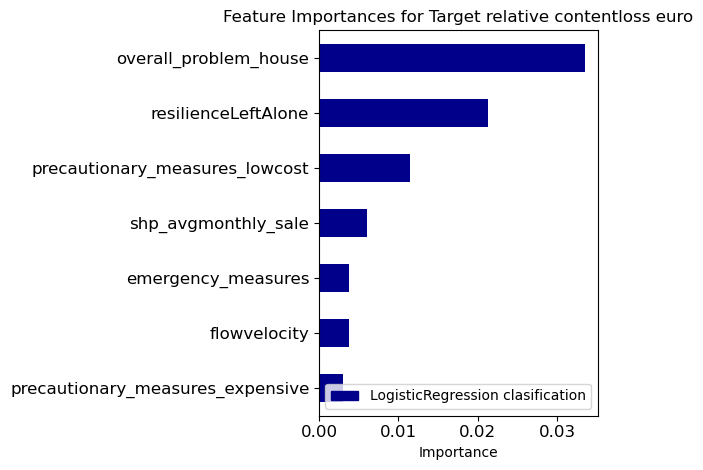

Dropping 0 records from entire dataset due that these values are nan in target variable
Keeping 263 records and 18 features
Index(['overall_problem_house', 'resilienceLeftAlone',
       'precautionary_measures_lowcost', 'shp_avgmonthly_sale',
       'emergency_measures', 'flowvelocity',
       'precautionary_measures_expensive'],
      dtype='object')
total features: 18
dropped features: 11
selected 7 features: 
['overall_problem_house', 'resilienceLeftAlone', 'precautionary_measures_lowcost', 'shp_avgmonthly_sale', 'emergency_measures', 'flowvelocity', 'precautionary_measures_expensive']

Saving selected features to disk: ../selected_features/can_tho/chance_of_loss/final_predictors_Target_relative_contentloss_euro.xlsx

LogisticRegression
           nobs  median  mean min max  variance
empirical   263    0.00  0.42  [0, 1]      0.24
predicted   263    1.00  0.53  [0, 1]      0.25


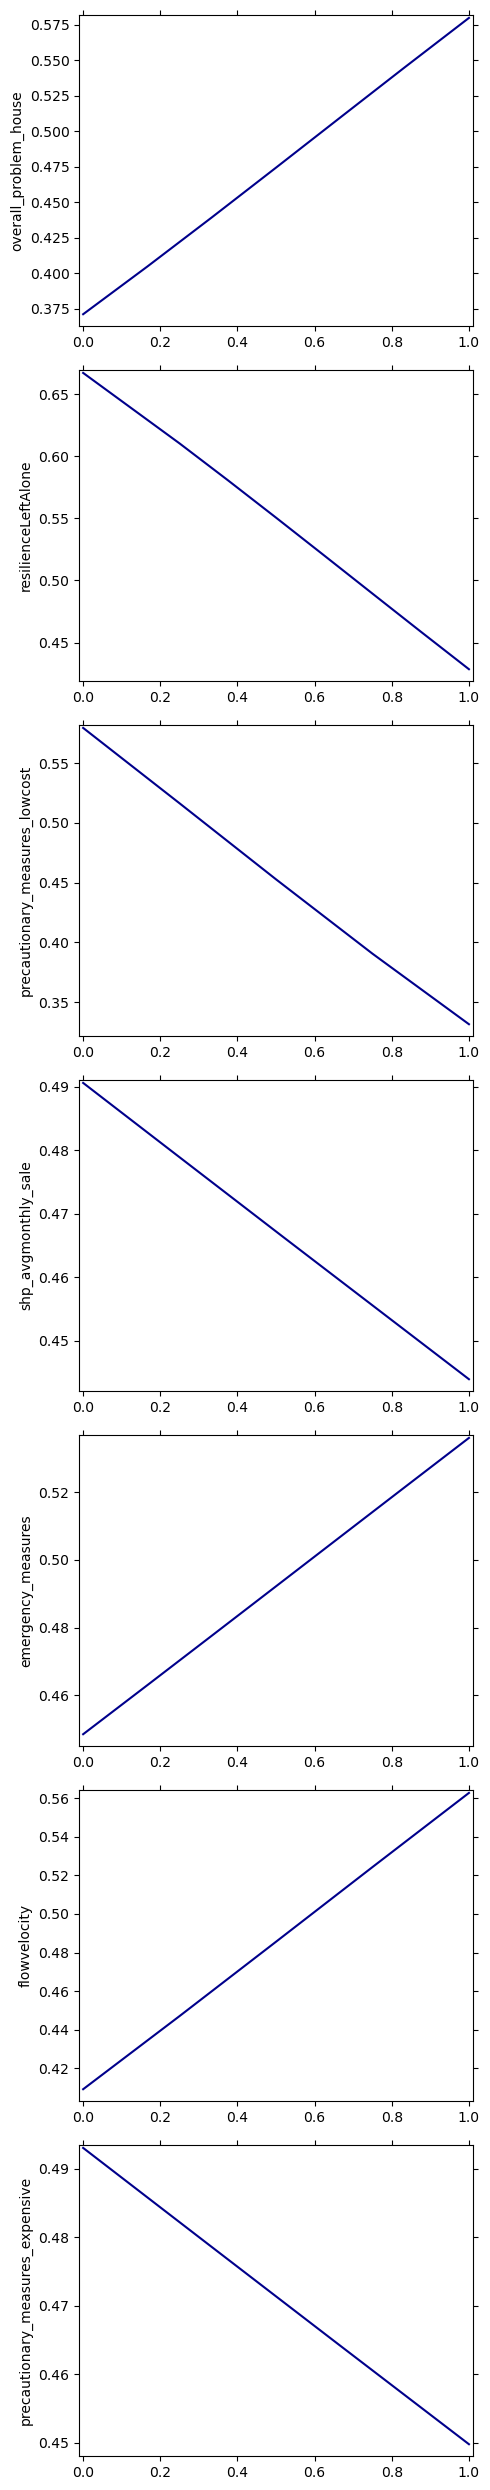

In [113]:
print(df_candidates.shape)

## delete features with more than 10% missing values
# print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


## Fit model

score_metrics = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1_macro": "f1_macro",
}

## test drop flow velocity due to diffenret flooding sources (eg. overwhelmed draingage systems)
# df_candidates = df_candidates.drop("flowvelocity", axis=1)
print(df_candidates.columns)

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 

# pipelines = ["pipe_logreg_bag"]
pipelines = ["pipe_logreg"]
#pipelines = ["pipe_sgd"] # with logreg loss and en penality

eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    # TIME0 = datetime.now()

    ## load model pipeline and get model name
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    

    print( f"\n  ############### Applying {model_name} on {target}:  ###############\n")

    ## load hyperparameter space
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging is used, adapt hyperparameeter names
    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}


    ## load input dataset
    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    # ## test impact of median imputation on model performance
    # print("test impact of median imputation on model performance")
    # df_Xy[X_names] = df_Xy[X_names].apply(lambda x: x.fillna(x.median()),axis=0)


    ## set target as binary class
    df_Xy[target][df_Xy[target] > 0] = 1
    df_Xy[target] = df_Xy[target].astype("Int64")

    ## clean df from remaining records containg nan
    df_Xy.dropna(inplace=True) ## TODO test with only nan in target removed

    print("Amount of missing target values should be zero: ", df_Xy[target].isna().sum())

    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        (df_Xy[target][df_Xy[target] == 0.0]).count(),
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]



    if model_name != "crf":

        # ## save evaluation set for later usage in feature importance
        # eval_sets[f"{model_name}"] = df_Xy #pd.concat([df_Xy[target], X_crf], axis=1)         
        mf = t.ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=param_space,
            tuning_score="accuracy", # f1_macro
            cv=cv,
            kfolds_and_repeats=kfolds_and_repeats,
            seed=s.seed,
        )
        models_trained_ncv = mf.model_fit_ncv()  # pipe
        
        me = e.ModelEvaluation(
            models_trained_ncv=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrics=score_metrics,
            cv=cv,
            kfolds=kfolds_and_repeats[0],
            seed=s.seed
        )
        model_evaluation_results = me.model_evaluate_ncv(prediction_method="predict_proba")


        ## visual check if hyperparameter ranges are good or need to be adapted
        for i in range(len(model_evaluation_results["estimator"])):
            print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


        ## store models evaluation 
        models_scores[model_name] =  {
            k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
        } # get evaluation scores, metric names start with "test_<metricname>"


        ## Final model

        ## get final model based on best MAE score during outer cv
        best_idx = list(models_scores[model_name]["test_accuracy"]).index(max(models_scores[model_name]["test_accuracy"]))
        final_model = model_evaluation_results["estimator"][best_idx]
        print("used params for best model:", final_model.best_params_)  # use last model as the best one
        final_model = final_model.best_estimator_

        ## predict on entire dataset and save final model
        y_pred = final_model.predict(X) 
        final_models_trained[model_name] = final_model 
        joblib.dump(final_model, f"../models_trained/can_tho/chance_of_loss/final_models/{model_name}_{target}.joblib")

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, repeats=5)

        ## regression coefficients for linear models
        with contextlib.suppress(Exception):   # <-- better than: try and bare except

            models_coef[model_name] = me.calc_regression_coefficients(final_model)

            outfile = f"../models_evaluation/can_tho/chance_of_loss/regression_coefficients_{model_name}_{target}.xlsx"
            models_coef[model_name].round(3).to_excel(outfile, index=True)
            print("Regression Coefficients:\n", models_coef[model_name].sort_values("probabilities", ascending=False), f"\n.. saved to {outfile}")


    # filename = f'./models_trained_ncv/{model_name}_{target}.sav'
    # pickle.dump(model, open(filename, 'wb'))
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    # models_trained[model_name] = model_evaluation_results["estimator"]
    predicted_values[model_name] = me.residuals

    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")

    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_feature_importances.iloc[:5].index.to_list())
    #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]

    # print(
    # f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds()} seconds\n"
    # )

# SDG without threshold: model performance measured in Accuracy (std) on outer CV: 0.583 (0.010)
# LogReg without median imputation - no model improvement
# LogReg without cases which had more than 1000€ absolute losses - no model improvement
# # LogReg with upper threshold of 2000 €: model performance measured in Accuracy (std) on outer CV: 0.598 (0.085)  
# LogReg with upper threshold of 2000 € without flowvelo: model performance measured in Accuracy (std) on outer CV: 0.581 (0.078)
# LogReg with upper threshold of 2000 € with f1_macro for model tuning: model performance measured in Accuracy (std) on outer CV:  0.594 (0.082)
# LogReg with upper threshold of 2000 € and only first 100 records: model performance measured in Accuracy (std) on outer CV: 0.644 (0.151)  

## Print model evaluation based on performance on outer cross-validation 
classifier_model_evaluation = pd.DataFrame(models_scores[model_name]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
classifier_model_evaluation_std = pd.DataFrame(models_scores[model_name]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([classifier_model_evaluation, classifier_model_evaluation_std], axis=1)
model_evaluation.columns = [f"{model_name}_score", f"{model_name}_score_std"]

model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"../models_evaluation/can_tho/chance_of_loss/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
print("Outer evaluation scores:\n", model_evaluation.round(3), f"\n.. saved to {outfile}")


## Feature Importances 
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot[f"{model_name}_importances"] >= 0.00, : ] 
df_feature_importances_plot = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=True)


## TODO update with plt_fi() func as soons a its more flexible in number of models passed to func()
plt.figure(figsize=(30, 22), facecolor="w")
fig = df_feature_importances_plot.plot.barh(
    color="darkblue",
    width=0.5,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")

top_bar = mpatches.Patch(color="darkblue", label=f"{model_name} clasification")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.show()

 
fig.get_figure().savefig(f"../models_evaluation/can_tho/chance_of_loss/feature_importances_{target}.jpg", bbox_inches="tight")
plt.close()


# f.plot_stacked_feature_importances(
#     df_feature_importances_plot["LogisticRegression_importances"],
#     target_name=target,
#     model_names_plot = ("Logistic Regression"),
#     outfile=f"../models_evaluation/chance_of_loss/feature_importances_{target}.jpg"
# )


### Save final feature space 
## The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")


## sort features by their overall importance (weighted sum across across all features) 
final_feature_names = df_feature_importances_plot[f"{model_name}_importances"].sort_values(ascending=False).index##[:10]
print(final_feature_names)

## save importnat features, first column contains target variable
fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../selected_features/can_tho/chance_of_loss/final_predictors_{target}.xlsx"
)


### Partial dependence
## PDP shows the marginal effect that one or two features have on the predicted outcome.

## store partial dependences for each model
pdp_features = {a : {} for a in [model_name]}

for model_name in [model_name]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         
        # get Partial dependences for sklearn models
        partial_dep = me.get_partial_dependence(**features_info)

        pdp_features[model_name][predictor_name] = partial_dep


## Plot PDP

most_important_features = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=False).index

categorical = [] # ["flowvelocity", "further_variables .."]
ncols = 1
nrows = len(most_important_features[:10])
idx = 0

plt.figure(figsize=(5,25))
# plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip([model_name], ["darkblue"], [0]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, 
            feature_name=feature, 
            partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p

    idx = idx + 1


#plt.subplots_adjust(top=0.2)
plt.savefig(f"../models_evaluation/can_tho/chance_of_loss/pdp_{target}.jpg", bbox_inches="tight")


# ### Empirical median ~ predicted median
# Compare median and mean of predicted  vs observed target values
for k,v in predicted_values.items():
    print(f"\n{k}")
    print(em.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))


# HCMC LogReg : with removed 4 highest abs loss removed ACC 0.61
#             LogisticRegression_score  LogisticRegression_score_std
# accuracy                       0.61                          0.08
# precision                      0.53                          0.10
# recall                         0.57                          0.15
# f1_macro                       0.59                          0.08 

In [36]:
 df_Xy[target].isna()

'logreg'

In [1]:
model_coef[f"LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef[f"LogisticRegression_selfbuilt"]

NameError: name 'X' is not defined

In [24]:
# models_cv_result.keys()

NameError: name 'models_cv_result' is not defined

In [ ]:
## scoring=ACC 5*5 ACC:
# outer CV: ACC: 0.573 (0.087)
# outer CV: precision: 0.491 (0.105)
# outer CV: recall: 0.607 (0.176)
# outer CV: F1: 0.529 (0.114)

## scoring=ACC 10*5 ACC: 

In [ ]:
# ValueError: Classification metrics can't handle a mix of binary and continuous targets
predicted_probabilities
#pd.Series(y_pred).describe()
# from sklearn.metrics import classification_report
print(classification_report(predicted_probabilities["y_empirical"], predicted_probabilities["y_pred_value"])) # baggin: ACC: 0.58
              

              precision    recall  f1-score   support

         0.0       0.68      0.59      0.63       153
         1.0       0.53      0.62      0.57       114

    accuracy                           0.61       267
   macro avg       0.61      0.61      0.60       267
weighted avg       0.62      0.61      0.61       267



In [ ]:
#logistic_reg_cv
# ?logistic_reg
# ?KFold
predicted_probabilities

## use continous  probability values for weights in BN
# --> gives chance that a certain vlaue of loss occures 
## model bias over/underestimation of losses


,y_empirical,y_pred_value,y_pred_value_proba
0,0,1,0.547010
1,0,1,0.602796
2,0,0,0.771077
4,0,0,0.615087
5,0,0,0.756869
...,...,...,...
385,0,1,0.549029
386,0,1,0.586166
387,0,1,0.553343
388,0,1,0.503891


In [ ]:
model_coef["LogisticRegression_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["LogisticRegression_selfbuilt"].sort_values("features")

,Coefficients,Standard Errors,t values,Probabilities,features
6,0.1823,0.001,243.430,0.00000,b_area
5,0.0361,0.004,8.996,0.00000,bage
13,0.2134,0.120,1.778,0.07658,contaminations
10,0.3851,0.193,1.994,0.04721,emergency_measures
4,-0.0614,0.001,-63.443,0.00000,flood_experience
3,0.7565,0.436,1.734,0.08413,flowvelocity
9,0.4937,0.005,90.415,0.00000,hh_monthly_income
0,-0.8673,0.223,-3.888,0.00013,intercept
1,0.1942,0.001,165.652,0.00000,inundation_duration_h
14,0.6270,0.028,22.411,0.00000,overall_problem_house


In [ ]:
model_coef["logreg_freg"].sort_values("features")

KeyError: 'logreg_freg'

## Evaluation

#### Coefficients of Logistic Regression 

LogReg:  The algorithm estimates the probability of an event occurring by fitting a logistic function to a set of input variables. The coefficients for logistic regression are used to measure the strength of the relationship between the input variables and the output variable.
LogReg doesnt reduce the influence of correlated variables on the model (in contrast to the rregularization termo of Linear models.)

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
model_coef["logreg_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()
model_coef["logreg_selfbuilt"].sort_values("features")


,Coefficients,Standard Errors,t values,Probabilities,features
6,0.2446,0.001,341.864,0.00000,b_area
5,0.1925,0.004,49.143,0.00000,bage
14,0.3394,0.114,2.966,0.00332,contaminations
11,0.4738,0.189,2.504,0.01296,emergency_measures
4,-0.0147,0.001,-15.279,0.00000,flood_experience
3,0.6637,0.422,1.573,0.11694,flowvelocity
10,0.7113,0.005,135.395,0.00000,hh_monthly_income
0,-0.9006,0.230,-3.915,0.00012,intercept
1,0.1944,0.001,173.376,0.00000,inundation_duration_h
15,0.7486,0.027,27.741,0.00000,overall_problem_house


In [ ]:
#df_candidates.resistant_material_building_impl.value_counts()

AttributeError: 'DataFrame' object has no attribute 'resistant_material_building_impl'

In [ ]:
model_coef["logreg_selfbuilt"].sort_values("features")

,Coefficients,Standard Errors,t values,Probabilities,features
13,0.2246,0.001,294.144,0.00000,b_area
12,0.1489,0.004,35.504,0.00000,bage
19,0.4048,0.122,3.321,0.00104,contaminations
9,-0.2709,0.031,-8.773,0.00000,electricity_higher_impl
7,0.4930,0.032,15.528,0.00000,elevation_building_impl
18,0.2083,0.208,1.004,0.31662,emergency_measures
11,-0.0781,0.001,-72.531,0.00000,flood_experience
10,-0.5034,0.087,-5.783,0.00000,flood_protections_impl
3,0.8193,0.453,1.809,0.07178,flowvelocity
17,0.5616,0.006,99.361,0.00000,hh_monthly_income


In [ ]:
# #models_trained["LogisticRegression"]
# #print(model_coef.keys())
# #model_coef

# import statsmodels.api as sm

# df_candidates_sm = pd.get_dummies(df_candidates_t, columns=[target], drop_first=True)
# y_sm = df_candidates_sm[[target+"_1"]]
# X_sm = df_candidates_sm.drop(target+"_1", axis=1)
# sm_model = sm.Logit(y_sm, sm.add_constant(X_sm)).fit(disp=0)
# print(sm_model.pvalues)
# sm_model.summary()




In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(model_coef["LogisticRegression"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in dollars/hour. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]

### Confusion matrix

,0,1
0,68,82
1,35,74


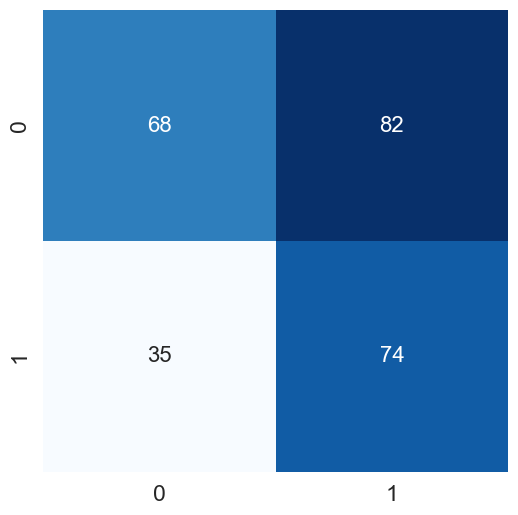

In [ ]:
## based on neste cv
f.plot_confusion_matrix(
    predicted_values["y_pred"],
    predicted_values["y_pred"],
    show_absolute=True,
    show_normed=True,
    colorbar=False,
    model_name="Logistic_Regression", target_name=target)

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean / variance / std  compared to empirical distribution

In [ ]:
# print("Logistic Reg (binary classification): ", target)
# e.empirical_vs_predicted(
#     X, y.astype(int),
#     models_list=[final_models_trained["LogisticRegression"].named_steps["model"]]    
#     #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
# )

# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Logistic Reg (binary classification):  Target_relative_contentloss_euro


IndexError: list index out of range

In [ ]:
# #scores = cross_validate(elastic_net, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# #pd.DataFrame(scores).set_index("test_score").sort_index().T

# # #Snippet from: https://ubc-cs.github.io/cpsc330/lectures/08_hyperparameter-optimization.html#exhaustive-grid-search-sklearn-model-selection-gridsearchcv
# #pd.DataFrame(elastic_net_cv.cv_results_).set_index("rank_test_score").sort_index().T
# pd.DataFrame(model.cv_results_)[
#         [                                   # only important cv evaluation metrics 
#             "mean_test_score",
#             "mean_fit_time",
#             "rank_test_score",
#             "param_name__estimator__C",
#             "param_name__estimator__penalty",
#             "param_name__estimator__l1_ratio",
#             "param_name__estimator__max_iter"
#         ]
#     ].set_index("rank_test_score").sort_index().T


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
## reload models

print(targets)
target = targets[0]

logistic_reg_eval = pickle.load(open(f"./models_trained/logisticreg_{target}.sav", 'rb'))
#elastic_net_eval.get_params()


['Target_contentloss_euro', 'Target_businessreduction']


### Feature importance

In [ ]:
## TODO test to get std of FI _ C:\Users\Anna\Documents\UNI\MA_topic\recycling\sm2t-traffic-speed-model-partial-dependence\SM2T\sm2t-traffic-speed-model_partialDep\traffic_speed_model\modelling.py
#    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)  # based on RF_fi_ 

#plt.rcParams['axes.grid'] = 'none'
#s = df_feature_importances

<Figure size 3000x2200 with 0 Axes>

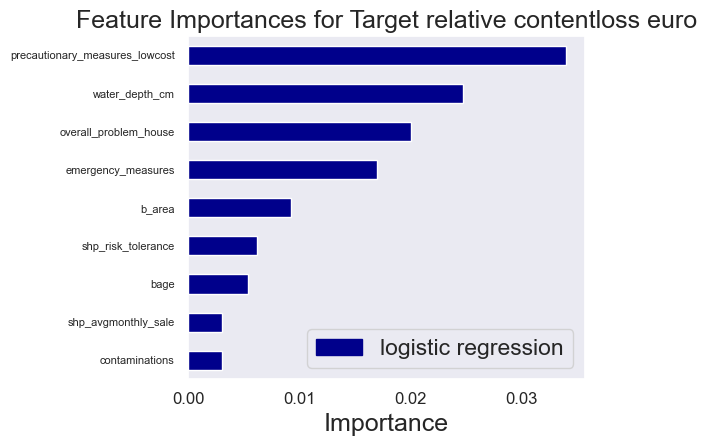

In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = s
df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances >= 0.0001, : ] 
df_feature_importances = df_feature_importances.sort_values("logreg_importances", ascending=True)

plt.figure(figsize=(30, 22), facecolor="w")
df_feature_importances.plot.barh(
    color="darkblue",
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="logistic regression")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
#plt.axes().set_facecolor("w")
plt.grid(False)
#plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



###  Partial dependences

In [ ]:
## store partial dependences for each classification algorithm

pdp_features = {a : {} for a in ["LogisticRegression"]}

me = e.ModelEvaluation()


for model_name in ["LogisticRegression"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = me.get_partial_dependence(
                **features_info
            )
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 
Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 


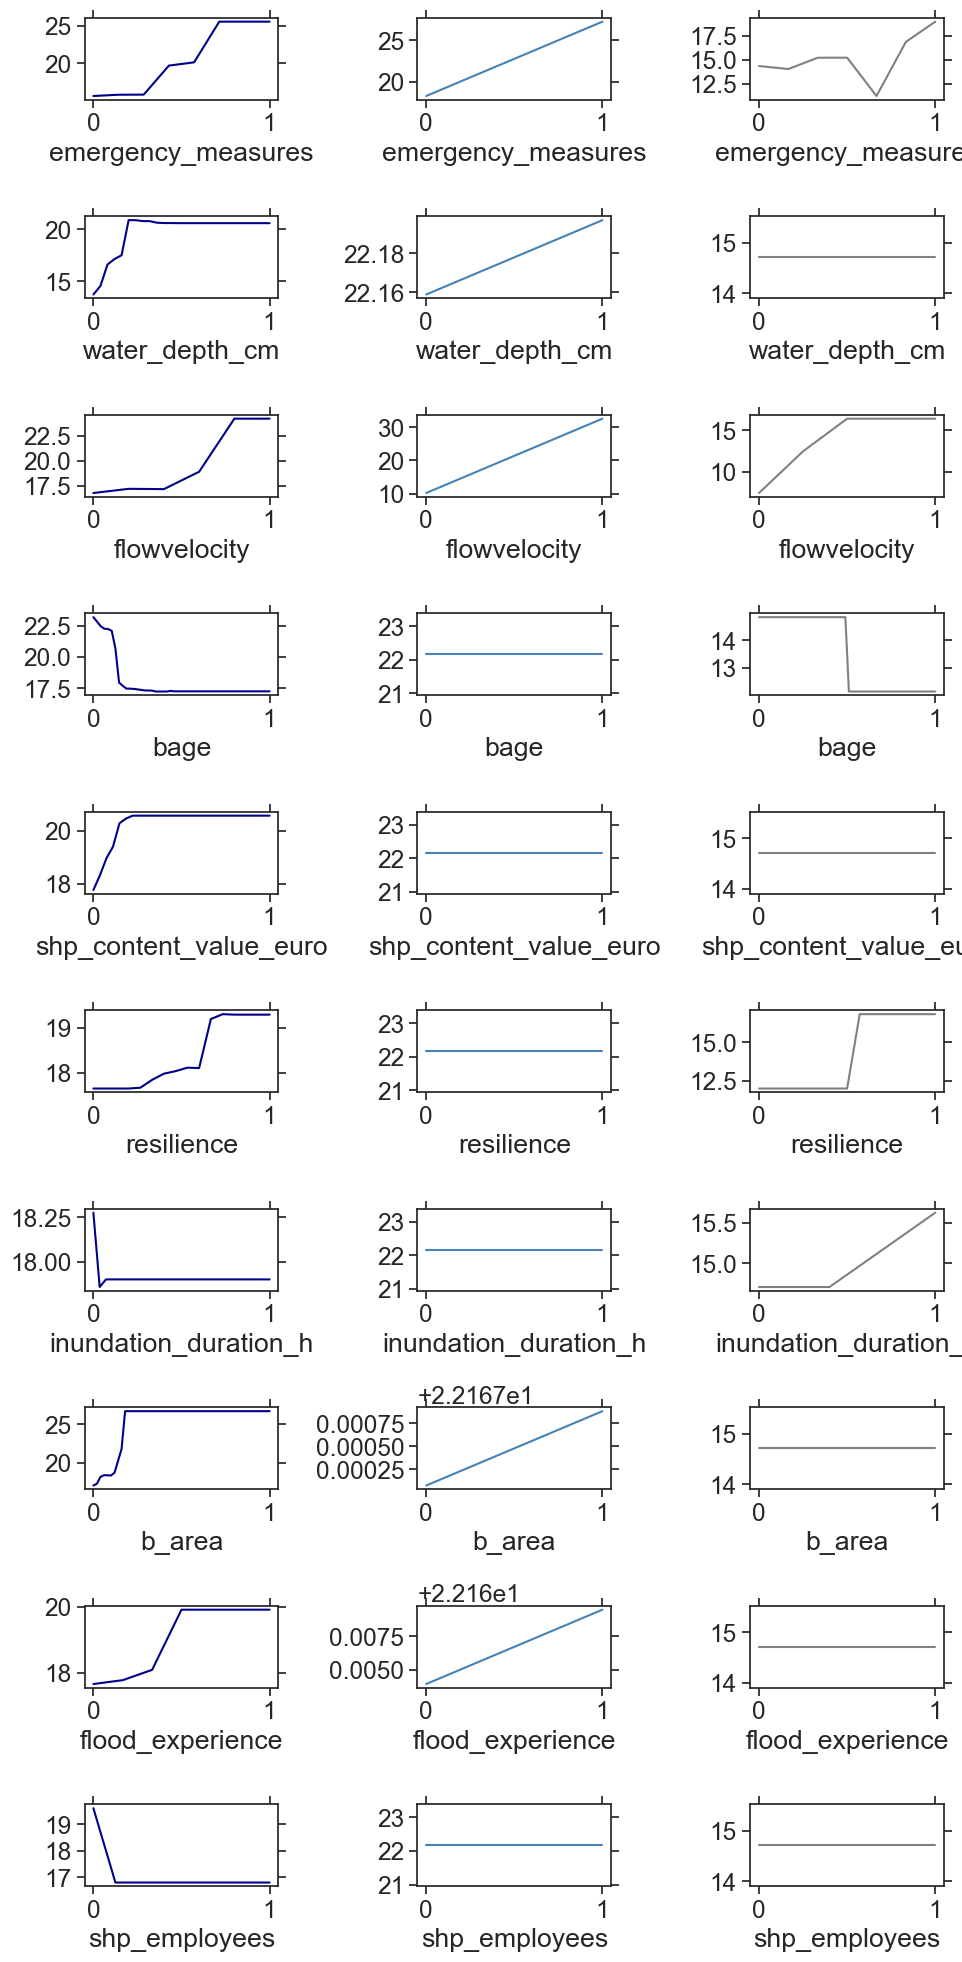

In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            outfile=f"../models_evaluation/chance_of_loss/pdp_{target}.jpg",
            **feature_info
            )
        p

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")
